# Cis-activation and cis-inhibition model

**Background**: Nandagopal et al. 2019 came up with a model in the cis activation paper that enabled cis activation and inhibition to some extent. However, their model only considered interconversion between active and inactive cis complexes, without biological justification. In my model, I allow free receptor and ligand to either form active or inactive complexes, and active and inactive cannot directly interconvert without dissociation.

![Cis Notch Model](cis_model_schematic.png)

# Note: the k values above take different values for $C^-$ formation vs. $C^+$, corresponding to distinct $K_d$ values in the code below.

### Variables:

- $R$ is surface receptor concentration at cell interface
- $N$ is activated receptor (NICD) concentration
- $L$ is surface ligand concentration
- $C^+$ = $R:L$, trans-like receptor-ligand complex
- $C^-$ = $R:L$, true 'cis' receptor-ligand complex
- $i$ is index of receptor. $i = \{1, 2, 3\}$ for receptor = {Notch1, Notch2, Notch3}.
- $j$ is index of ligand. $j = \{1, 2, 3, 4\}$ for ligand = {Dll1, Dll4, Jag1, Jag2}.

### Parameters

- $\alpha_L$, surface ligand production rate
- $\alpha_R$, surface receptor production rate
- $\gamma_L$, surface ligand endocytosis rate (unstimulated)
- $\gamma_R$, is surface receptor endocytosis rate
- $\gamma_C$, endocytosis rate of true cis receptor-ligand complexes ($C^-$)
- $\gamma_T$, surface ligand endocytosis rate (stimulated) - receptor activating
- $\gamma_{N}$, activated receptor degradation rate (known! ~75 min)
- $d_R$, rate of leaky (ligand-independent) receptor activation
- $K_d$, **relative** equilibrium dissociation constant

## ODEs and other equations

\begin{align}
L_{tot} = L_{t_{tot}} + L_{c_{tot}}; L_{tot} = L_c + L_t + C^+ + C^-; R_{tot} = R + C^+ + C^-
\end{align}

\begin{align}
\frac{dL_{tot}}{dt} = \alpha_L - \gamma_{L} (L_{tot} - C^+ - C^-) - \gamma_R C^+ - \gamma_C C^- - \gamma_T C^+ 
\end{align}

\begin{align}
\frac{dR_{tot}}{dt} = \alpha_R - \gamma_{R} (R_{tot} - C^-) - \gamma_C C^- - \gamma_T C^+  
\end{align}

\begin{align}
\frac{dN}{dt} =  \gamma_T C^+ - \gamma_{N} N
\end{align}

With leaky activation:

\begin{align}
\frac{dL_{tot}}{dt} = \alpha_L - \gamma_{L} (L_{tot} - C^+ - C^-) - \gamma_R C^+ - \gamma_C C^- - \gamma_T C^+ 
\end{align}

\begin{align}
\frac{dR_{tot}}{dt} = \alpha_R - \gamma_{R} (R_{tot} - C^-) - \gamma_C C^- - \gamma_T C^+ - d_R (R_{tot} - C^- - C^+)
\end{align}

\begin{align}
\frac{dN}{dt} =  \gamma_T C^+ - \gamma_{N} N + d_R (R_{tot} - C^- - C^+)
\end{align}

EQTK can be used to compute equilibrium concentrations promiscuously binding species, but it can't be used to compute equilibrium concentrations of just two species that can bind in two different orientations to form two distinct 'types' of complexes. Thus, we must find a work-around to solve for $C^+$ and $C^-$ using EQTK.

**Ideas:**
1. Free ligand can exist in one of two 'conformations' which we can think of as distinct molecular species or states: the 'trans' state and the 'cis' state. Biophysically, the true ligand structure is identical in each of these cases, and what is really different is the membrane topology--this works if we think of each protein species as a complex of ligand and membrane. 
    - I think we can then determine how much $L_t$ and $L_c$ ligand we have using a probabilistic model.
    - This allows us to use EQTK to represent the formation of $C^+$ and $C^-$.
\begin{align}
R + L_t \rightleftharpoons C^+ \overset{\gamma_T}{\rightarrow} N
\end{align}

\begin{align}
C^+ \overset{\gamma_R}{\rightarrow} Ø
\end{align}

\begin{align}
R + L_c \rightleftharpoons C^- \overset{\gamma_C}{\rightarrow} Ø
\end{align}

\begin{align}
L_c \rightleftharpoons L_t
\end{align}

Then this is the only change to the above equations:

\begin{align}
L_{tot} = L_c + L_t + C^+ + C^-
\end{align}

We can then solve for $C^+$ and $C^-$ using EQTK.

### Non-dimensionalization

All concentration variables are relative to $K_d$. This works out so that the production rates ($\alpha$) are also ratios of true production rate over $K_d$. 



In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import numba
import eqtk
import pandas as pd

# # For interactive plots
# import ipywidgets

# Import plotting stuff
import matplotlib.pyplot as plt
import seaborn as sns
# Set matplotlib rc params.
rc = {'lines.linewidth' : 2, 'axes.labelsize' : 20, 'legend.fontsize': 12,
        'axes.titlesize' : 25, 'xtick.labelsize': 15, 'ytick.labelsize': 15}

sns.set(rc=rc)
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
def assess_steady_state_convergence(RLN, interval, convergence_crit):
    """Determines whether the system has reached
    steady-state."""
    
    converged = True
    
    # Compute gradient across last hour and compute percent difference
    
    back_idx = int(60 / interval + 1)
    
    # initialize
    (R_err, L_err, N_err) = (0.0, 0.0, 0.0)
    
    # Replace values while avoiding divide by zero errors
    # Multiply by 100 to get percent difference
    if RLN[-1,0] != 0:
        R_err = 100 * abs(RLN[-1,0] - RLN[-back_idx,0]) / RLN[-1,0]
    if RLN[-1,1] != 0:
        L1_err = 100 * abs(RLN[-1,1] - RLN[-back_idx,1]) / RLN[-1,1]
    if RLN[-1,2] != 0:
        L2_err = 100 * abs(RLN[-1,2] - RLN[-back_idx,2]) / RLN[-1,2]
    
    RLN_err = np.array((R_err, L_err, N_err))
    
    # Evaluate convergence   
    failed_arr = RLN_err > convergence_crit
    
    if np.sum(failed_arr) > 0:
#         print('The system has not reached steady state.')
        
        converged = False
        
    return converged

In [3]:
def solve_EQTK(c0_vect, stoich, K_vect):
    '''Takes in:
    - c0_vect = initial concentrations of all species in proper order
    - stoichiometric matrix
    - K_vect = list of Kd values in proper order '''

    N = stoich
    
    c = eqtk.solve(c0_vect, N, K_vect, units=None)
    
    R, Lt, Lc, C_plus, C_minus = c #all of the steady state concentrations after equilibrium is reached 
    
    # Sanity check of mass conservation:
    Rtot = c0_vect[0]
         
    return c

In [4]:
def plot_dynamics(t, y_vals, normalized=False, 
                  normalize_to_max=True, leg_loc='center right', 
                  leg_lab = ('Total receptor','Total ligand',
                             'Activated receptor','Trans R:L complex'),
                  xlab = 'time (hr)', ylim = False,
                  ylab = 'dimensionless conc.', title = '',
                 filesave = 'NA'):
    """Convenient plotting function for results"""
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    
    # Get plot of stimulus dynamics

    if normalized:
        ylab = 'normalized ' + ylab
        if normalize_to_max:
            ax = plt.plot(t, y_vals[:,0]/y_vals[:,0].max())
            ax = plt.plot(t, y_vals[:,1]/y_vals[:,1].max())
            ax = plt.plot(t, y_vals[:,2]/y_vals[:,2].max())
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[:,3].max())
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[:,4].max())

        else:
            ax = plt.plot(t, y_vals[:,0]/y_vals[-1,0])
            ax = plt.plot(t, y_vals[:,1]/y_vals[-1,1])
            ax = plt.plot(t, y_vals[:,2]/y_vals[-1,2])
            if np.shape(y_vals)[1] > 3:
                ax = plt.plot(t, y_vals[:,3]/y_vals[-1,3])
            if np.shape(y_vals)[1] > 4:
                ax = plt.plot(t, y_vals[:,4]/y_vals[-1,4])

    else:
        ax = plt.plot(t, y_vals[:,0])
        ax = plt.plot(t, y_vals[:,1])
        ax = plt.plot(t, y_vals[:,2])
        if np.shape(y_vals)[1] > 3:
            ax = plt.plot(t, y_vals[:,3])
        if np.shape(y_vals)[1] > 4:
            ax = plt.plot(t, y_vals[:,4])

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if ylim != False:
        plt.ylim(ylim)
    plt.legend(leg_lab,loc=leg_loc, fontsize = 14)
    plt.title(title, size=22)
    
    if filesave != 'NA':
        print('image saved.')
        filename =  '/Users/catherineko/Desktop/FSRI/Research/temp/' + filesave +  '.pdf'
        plt.savefig(filename, bbox_inches='tight', format='pdf')
    
    return ax

In [5]:
def get_steady_state_vals(RLN, interval, convergence_crit):
    '''Extracts steady-state values from end
    of simulation and reports percent difference 
    across last hour of simulation to assist 
    evaluation of whether steady-state was reached.
    Convergence criterion is the maximum percent
    difference allowed before we say the system has 
    reached steady-state. E.g. 1 for one percent.'''
    
    # Compute steady state vals
    
    R0 = RLN[-1,0]
    L0 = RLN[-1,1]
    N0 = RLN[-1,2]
    
    RLN0 = np.array((R0, L0, N0)) 
    
    # Determine whether system has reached steady-state
    
    converged = assess_steady_state_convergence(RLN, interval, convergence_crit)
    
    if converged:
        return RLN0
    else:
        return np.array((np.nan, np.nan, np.nan))

In [6]:
def concat_initial_value(RLN, RLN_initial, hr, tpts):
    """Adds on initial value to simulation output
    in order to see how 'mixing' senders and receivers
    altered receptor and ligand levels.
    Can take RLN or RLNT of any shape as long as the
    dimensions of RLN and RLN_initial are compatible."""
    
    # concat on initial values
    RLN = np.concatenate((RLN_initial, RLN), axis = 0)
    
    # update t accordingly:
    t = np.linspace(0, hr + (hr/tpts), tpts+1)
    
    return RLN, t

In [7]:
def compute_cis_activation_potency(N_vect): #peak over leaky 
    '''This function returns the peak activation
    over leaky activation (latter assumed to be first 
    N-value).'''
    
    return np.around(np.max(N_vect) / N_vect[0], decimals = 2)

def compute_cis_inhibition_potency(N_vect):#??? metric of cis inhibition
    '''This function returns the inhibitory potential,
    defined as how close to 'leaky' activation the inhibitory
    ligand dampens the signal.
    This is expressed as a fraction, where 1 is the maximal
    inhibition possible, and 0 = no inhibition.'''
    
    # (peak activation - activation at highest cis ligand level) / 
    # (peak activation - leaky activation)
    
    cis_inh = 100 * (np.max(N_vect) - N_vect[-1]) / (np.max(N_vect) - N_vect[0])
    
    return np.around(cis_inh, decimals = 2)


In [8]:
def titrate_ligand(aL_vect, params, hr, interval, convergence_crit):
    '''This runs a series of simulations to calculate
    steady-state N (NICD) values for a range of ligand 
    levels.
    aL_vect is the range of ligand values to explore'''
    
    N_vect = []
    
    for aL in aL_vect:
        
        Kd_t, Kd_c, aR, gR, dR, gT, aL_prev, gL, gC, gN = params
        params = Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN
        
        # Simulate
        RLN_initial, RLN, t = simulate_Notch_signaling(params, hr, interval)
        
        # get steady state value
        RLN0 = get_steady_state_vals(RLN, interval, convergence_crit)
        N = RLN0[2]
        
        N_vect.append(N)
        
    # Determine cis-activation potency
    cis_act = compute_cis_activation_potency(N_vect)
    
    # Determine cis-inhibition potency???
    cis_inh = compute_cis_inhibition_potency(N_vect)
        
    return np.array(N_vect), cis_act, cis_inh
    

In [9]:
def logistic(x, max_Lt_frac, inflection_pt, curvature):
    """Returns y value of logistic function at 
    x value(s) provided based on three curve parameters."""

    return max_Lt_frac / (1 + np.exp(curvature * (x - inflection_pt)))

Text(0.5, 0, '$C^-$')

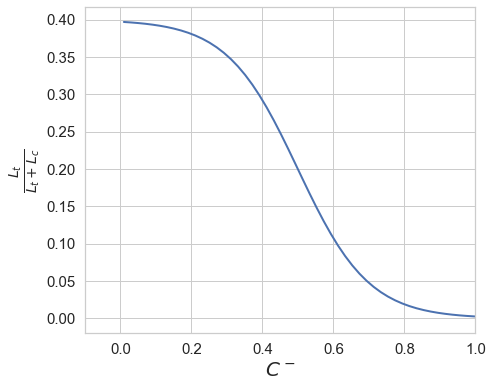

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# x = np.around(np.logspace(1.5, 3.4, num=100, base=10.0), decimals=4)
x = np.linspace(0.01,2, num=100)

inflection_pt = .5

plt.plot(x, logistic(x, .4, inflection_pt, 5 * (1/inflection_pt)))
# plt.xscale('log')
# plt.ylim(0,.42)
plt.xlim(-.1,inflection_pt * 2)
# plt.ylabel("$L_t$ / ($L_t$ + $L_c$)")
plt.ylabel("$\\frac{L_t}{L_t + L_c}$")
plt.xlabel("$C^-$")

In [11]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

In [12]:
#ODES
def dN_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of activated receptor (ICD); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return gT * C_p + dR * Rfree - gN * N


def dR_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface receptor (total receptor); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aR - gR * (R - C_m) - gC * C_m - gT * C_p - dR * Rfree


def dL_dt(R, L, N, Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params):
    """
    Dynamics of surface ligand (total ligand); I'm passing
    all variables and parameters for easy editing as needed.
    """
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    return aL - gL * (Lt_free + Lc_free) - gR * C_p - gC * C_m - gT * C_p


In [13]:
def get_equilibrium_concentrations(R, Lt, Lc, circuit_params):
    """Gathers info needed to call EQTK
    and calls EQTK."""
    
    # Unpack params
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    
    # Stoichiometry matrix
    N_1_2 = [[1,  1,  0, -1,  0], #(1)R + (1)L_t + (0)L_c ⇌ (-1)C^+ + (0)C^-
         [1,  0,  1,  0, -1]] #(1)R + (0)L_t + (1)L_c ⇌ (0)C^+ + (-1)C^-
    
    # Array of Kd values
    K_vect = [Kd_t, Kd_c]

    # Initial concentration vector to pass to EQTK
    c0_vect = np.array((R, Lt, Lc, 0.0, 0.0)) # R_tot, Lt_tot, Lc_tot, C_plus, C_minus
    if np.isnan(c0_vect).any():
        print(c0_vect)
    neg = c0_vect[c0_vect < 0]
    if len(neg) > 0:
        print('negative found:', c0_vect)
        
    # Compute T based on R_tot and L_tot using EQTK
    Rfree, Lt_free, Lc_free, C_plus, C_minus = solve_EQTK(c0_vect, N_1_2, K_vect)
        
    return np.array([Rfree, Lt_free, Lc_free, C_plus, C_minus])

In [144]:
def Euler_integration(RLN_initial, circuit_params, dt, t_stop):    
    """
    Use Euler integration to solve ODEs
    for model of Notch cis interactions
    between one ligand and one receptor.
    """    

    # Time points
    t = np.linspace(0, t_stop, int(t_stop / dt) + 1)
    
    # Initialize output arrays
    R0, L0, N0 = RLN_initial
    #print('starting R, L, N at', R0, L0, N0)
    R = R0 * np.ones_like(t)
    L = L0 * np.ones_like(t)
    N = N0 * np.ones_like(t)
    C_minus = 0.0 * np.ones_like(t)
    
    # Do Euler stepping, preventing negative concentration values
    for i in range(0, len(t) - 1):
            
        # Compute fraction of ligand in 'trans-like' vs. 'cis-like' state
        # This must use prev value of C_minus, because current value is computed based on Lt, Lc
        Lt, Lc = populate_ligand_states(L[i], 0.0)
        if i > 0:
            Lt, Lc = populate_ligand_states(L[i], C_minus[i-1]) # Lt_tot, Lc_tot
        
        # Get equilibrium concentrations
        EQTK_output = get_equilibrium_concentrations(R[i], Lt, Lc, circuit_params)
        Rfree, Lt_free, Lc_free, C_p, C_m = EQTK_output # equilibrium concentrations at current step i
        
        # Add C_minus to array for CURRENT INDEX
        C_minus[i] = C_m
#         print('C_minus', C_m)
            
        # Compute new R
        R[i+1] = R[i] + dt * dR_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if R[i+1] < 0:
            R[i+1] = 0
        
        # Compute new L
        L[i+1] = L[i] + dt * dL_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if L[i+1] < 0:
            L[i+1] = 0
        
        # Compute new N
        N[i+1] = N[i] + dt * dN_dt(R[i], L[i], N[i], Rfree, Lt_free, Lc_free, C_p, C_m, circuit_params)
        if N[i+1] < 0:
            N[i+1] = 0
        
    # Concatenate arrays
    #print('final C_minus = ', C_m)
    RLN = np.concatenate(([R,], [L,], [N,]), axis=0)
    RLN = np.transpose(RLN)
        
    return RLN, t


In [15]:
def simulate_Notch_signaling(circuit_params, hr, interval):
    """Runs Euler integration and returns 
    initial values (initial steady state) as 
    well as simulation output (with total receptor
    and ligand, not free) and time series.
    Takes as input one set of circuit parameters 
    and values that define the time series:
    - hr (simulation duration in hr) 
    - interval (time step in minutes)
    """
    
    # Define time series
    dt = interval / 60 # convert interval from minutes to hours
    
    # Start values at steady state
    Kd_t, Kd_c, aR, gR, dR, gT, aL, gL, gC, gN = circuit_params
    R0 = aR/(gR + dR)
    L0 = aL/gL
    N0 = dR * R0 / gN
    RLN_initial = (R0, L0, N0) 
    
    # Initiate Euler stepping
    RLN, t = Euler_integration(RLN_initial, circuit_params, dt, hr)

    # Return initial values and simulation output
    return RLN_initial, RLN, t

In [ ]:
def significant_change(aL_vals):
    new_list = []
    for i, aL in enumerate(aL_vals):
        if (i + 1) <= len(aL_vals) - 1:
            change = N_vect[i + 1] - N_vect[i]
            # print(aL_vals[i])
        if np.abs(change) > 0.05:
            new_list.append(1)
        else:
            new_list.append(0)
    new_array2 = np.array(new_list)
    return new_array2

## Define the experiment

1. We want to determine whether this model (under any reasonable parameter set) could enable cis-activation at low ligand levels and cis-inhibition at high ligand levels. We will start by simulating the Notch1-Dll4 combination.

To do this, we must generate a series of ligand concentrations (a virtual 'titration'), and 
- visualize what the curve of N (active NICD) looks like across that range
- define cis-activation and cis-inhibition metrics to compare parameter sets
    - cis-activation: N fold difference over 'leaky' activation
    - cis-inhibition: how completely cis-activation is 'stopped' at the highest ligand concentration, i.e. ($N_a$ [val. at peak activation] - $N_I$ [val. max inhibition]) / ($N_a$ [val. at peak activation] - $N_L$ [leaky activation])
    

2. We next want to ask whether this model enables cis activation without inhibition when the $K_{d_c}$ corresponds to a very weak 'cis' affinity. This is my hypothesis for how Notch2 differs from Notch1 in its cis-interactions with Delta ligands.


Parameters / ranges:
- $K_{d_c}$ should be varied in the range of ($0.01$ to $10$)?.
- $K_{d_t}$ should be in the range of ($0.01$ to $0.1$), which is reasonable for the Notch1-Dll4 $K_d$ relative to the Dll1-Notch1 $K_d$.
- $\alpha_R$ could take a wide range of values, but use $0.06$ or $0.4$. 
    - From $10^{-3}$ or to $10^3$ (times degradation rates).
    - Remember, these values are relative to true Notch1-Dll1 Kd.
- $d_R = \frac{\log(2)}{10h}$ or somewhere between 5-20h.
- $\gamma_{R} = \frac{\log(2)}{0.8h}$
- $\alpha_{L}$ could take a wide range of values, but use $0.06$ or $0.4$. 
- $\gamma_{L} = \frac{\log(2)}{0.3h}$
- $\gamma_{T(1,2)} = \frac{\log(2)}{0.07h}$
- $\gamma_N$ is fixed at $\frac{\log(2)}{1.25}$

starting R, L, N at 0.4563949037696249 0.0 0.00823048330444292
final C_minus =  0.0
starting R, L, N at 0.4563949037696249 0.04328085122666891 0.00823048330444292
final C_minus =  0.011271313919826173
starting R, L, N at 0.4563949037696249 0.13685405157872707 0.00823048330444292
final C_minus =  0.18483539010534858
starting R, L, N at 0.4563949037696249 0.43280851226668904 0.00823048330444292
final C_minus =  0.3461186612721616
starting R, L, N at 0.4563949037696249 1.3686703583409507 0.00823048330444292
final C_minus =  0.4260160796091324
starting R, L, N at 0.4563949037696249 4.328085122666891 0.00823048330444292
final C_minus =  0.4507007064228216
starting R, L, N at 0.4563949037696249 13.686617021707054 0.00823048330444292
final C_minus =  0.45823254537061975
Cis-activation fold-diff: 16.54
Cis-inhibition efficacy: 106.39 %


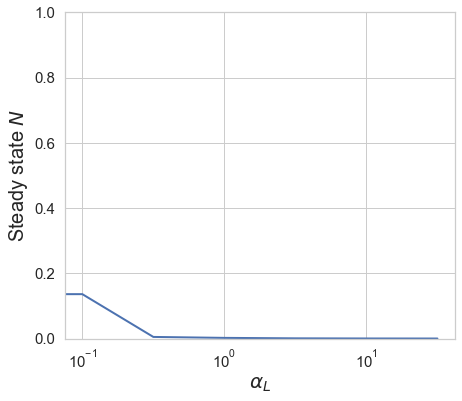

In [16]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t = 0.1
Kd_c = 0.1
aR = 0.4
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

# Define ligand range for titration- x axis for plot; adding ligands 
aL_vals = np.around(np.logspace(-1, 1.5, num=6, base=10.0), decimals=4)
aL_vals = np.insert(aL_vals, 0, 0)

circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

# Define time series
hr = 48.0 # simulation of 48 hours
interval = 5 # 5 minutes between time steps

convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

# Simulate ligand titration
N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                          hr, interval, convergence_crit)

# Print cis-activation and -inhibition metrics
print('Cis-activation fold-diff:', cis_act)
print('Cis-inhibition efficacy:', cis_inh, '%')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plt.plot(aL_vals, N_vect)
plt.ylabel('Steady state $N$')
plt.xlabel('$\\alpha_L$')
plt.ylim((0,1))
ax.set_xscale('log')

In [17]:
np.around(np.linspace(.05, 0.5, num=6), decimals=4)

array([0.05, 0.14, 0.23, 0.32, 0.41, 0.5 ])

starting R, L, N at 0.05704936297120311 0.0 0.001028810413055365
final C_minus =  0.0
starting R, L, N at 0.05704936297120311 0.00432808512266689 0.001028810413055365
final C_minus =  0.0006472369212812988
starting R, L, N at 0.05704936297120311 0.027310217124028077 0.001028810413055365
final C_minus =  0.0030261424282738716
starting R, L, N at 0.05704936297120311 0.1723010687333689 0.001028810413055365
final C_minus =  0.005647249552999603
starting R, L, N at 0.05704936297120311 1.087171701962696 0.001028810413055365
final C_minus =  0.006223365340147896
starting R, L, N at 0.05704936297120311 6.859538830063528 0.001028810413055365
final C_minus =  0.006314578356850272
starting R, L, N at 0.05704936297120311 43.2808512266689 0.001028810413055365
final C_minus =  0.006329122783598277
Cis-activation fold-diff: 71.72
Cis-inhibition efficacy: 0.0 %


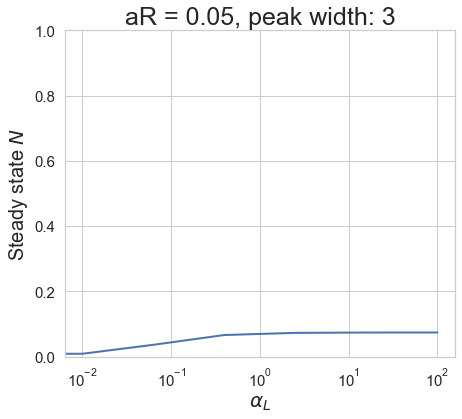

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  0.0007570120764733787
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0038443236568381934
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.007894345797005405
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.00875689648482617
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.008888049301823044
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.008908646921754672
Cis-activation fold-diff: 71.67
Cis-inhibition efficacy: 0.0 %


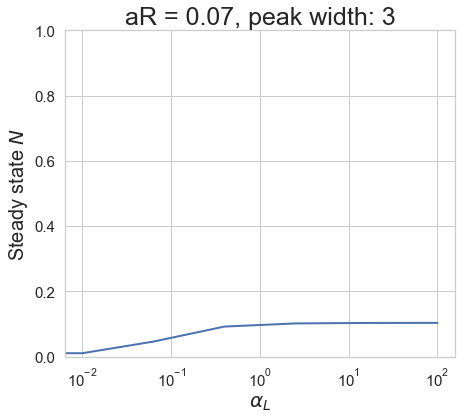

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.0008341655405128574
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0044837027778024474
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.010139538535374413
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.011333772274542334
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.011508225902969935
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.011535423240113822
Cis-activation fold-diff: 71.61
Cis-inhibition efficacy: 0.0 %


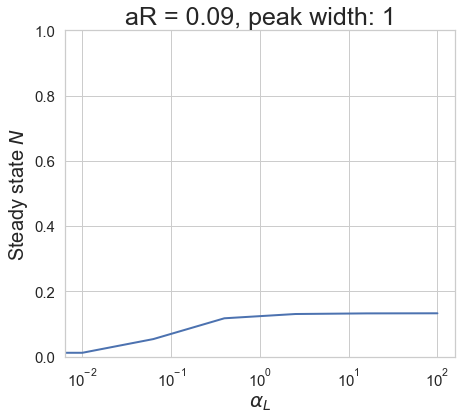

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.00089109629214024
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00498279381769298
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.012388283972732608
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.11494743380523464
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.12475290313861861
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12635823885322084
Cis-activation fold-diff: 62.85
Cis-inhibition efficacy: 101.3 %


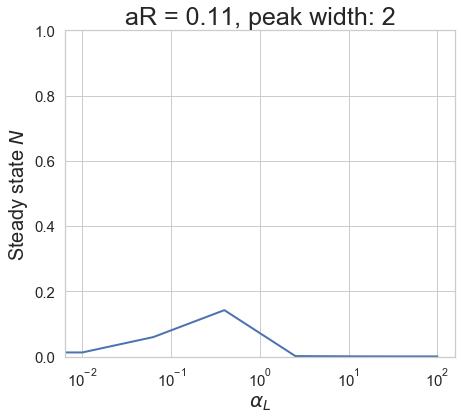

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  0.0009347227335528555
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.005375285356713051
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.014648614727450944
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.13658429983696696
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.14780134675240292
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.14965509283972092
Cis-activation fold-diff: 62.3
Cis-inhibition efficacy: 101.6 %


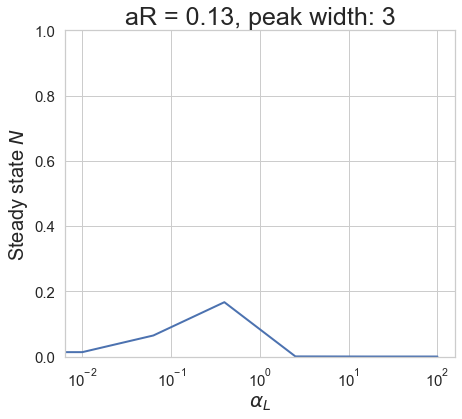

starting R, L, N at 0.17114808891360933 0.0 0.0030864312391660946
final C_minus =  0.0
starting R, L, N at 0.17114808891360933 0.00432808512266689 0.0030864312391660946
final C_minus =  0.000969168269183777
starting R, L, N at 0.17114808891360933 0.027310217124028077 0.0030864312391660946
final C_minus =  0.005687713896959664
starting R, L, N at 0.17114808891360933 0.1723010687333689 0.0030864312391660946
final C_minus =  0.016932469200732974
starting R, L, N at 0.17114808891360933 1.087171701962696 0.0030864312391660946
final C_minus =  0.15759992540415002
starting R, L, N at 0.17114808891360933 6.859538830063528 0.0030864312391660946
final C_minus =  0.17057934771404415
starting R, L, N at 0.17114808891360933 43.2808512266689 0.0030864312391660946
final C_minus =  0.17271511441200355
Cis-activation fold-diff: 61.69
Cis-inhibition efficacy: 101.64 %


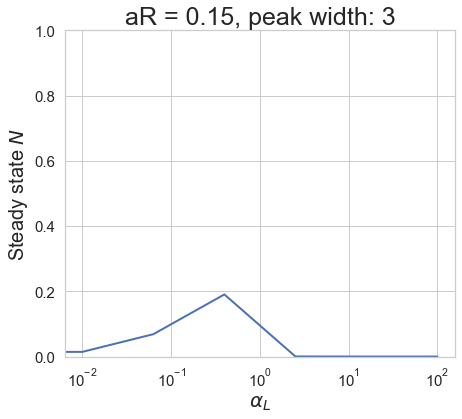

In [131]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t = 0.1
Kd_c = 0.1
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4)
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    # Define ligand range for titration- x axis for plot; adding ligands 
    aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
    aL_vals = np.insert(aL_vals, 0, 0)

    circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

    # Define time series
    hr = 48.0 # simulation of 48 hours
    interval = 5 # 5 minutes between time steps

    convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

    # Simulate ligand titration
    N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                              hr, interval, convergence_crit)

    # Print cis-activation and -inhibition metrics
    print('Cis-activation fold-diff:', cis_act)
    print('Cis-inhibition efficacy:', cis_inh, '%')
    
    # Added this in to quantify peak width 
    for i, element in enumerate(significant_change(aL_vals)):
        if element == 1:
            start_of_peak = i
            break

    for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
        if element == 1:
            end_of_peak = i + 1
            break

    peak_width = end_of_peak - start_of_peak
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))

    plt.plot(aL_vals, N_vect)
    plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
    plt.ylabel('Steady state $N$')
    plt.xlabel('$\\alpha_L$')
    plt.ylim((0,1))
    ax.set_xscale('log')
    plt.show()
    
    

In [19]:
peakrise = np.max(N_vect)-N_vect[0]
peakrise

0.1873181819185107

In [20]:
inhibition_drop = np.abs(N_vect[-1]-N_vect[0])
inhibition_drop

0.0030734445728515863

In [21]:
peakrise-inhibition_drop

0.18424473734565913

In [22]:
aL_vals

array([0.00000e+00, 1.00000e-02, 6.31000e-02, 3.98100e-01, 2.51190e+00,
       1.58489e+01, 1.00000e+02])

In [25]:
new_array = np.array((aL_vals,N_vect))

In [32]:
new_array.shape

(2, 7)

In [37]:
index_of_peak = np.argmax(N_vect)

In [38]:
aL_of_peak = aL_vals[index_of_peak]

0.3981

In [130]:
def significant_change(aL_vals):
    new_list = []
    for i, aL in enumerate(aL_vals):
        if (i + 1) <= len(aL_vals) - 1:
            change = N_vect[i + 1] - N_vect[i]
            # print(aL_vals[i])
        if np.abs(change) > 0.05:
            new_list.append(1)
        else:
            new_list.append(0)
    new_array2 = np.array(new_list)
    return new_array2

for i, element in enumerate(significant_change(aL_vals)):
    if element == 1:
        start_of_peak = i
        break
        
for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
    if element == 1:
        end_of_peak = i + 1
        break
        
peak_width = end_of_peak - start_of_peak


3


# Looping through Kd_t Kd_c and aR

In [140]:
def populate_ligand_states(L, C_minus_prev):
    """Computes fraction of free ligand (including protein
    and membrane state) that exists in trans-like vs. cis-
    like state (Lt vs Lc, respectively). This fraction 
    is computed based on a logistic function defined by
    three parameters that you must pass it.
    Returns Lt_tot, Lc_tot."""
    
    max_Lt_frac = 0.4 # 40%
    inflection_pt = .05 # TEMPORARY! MUST CHANGE
    curvature = 5 * (1/inflection_pt) # try 5 * 
    
    frac_Lt = logistic(C_minus_prev, max_Lt_frac, inflection_pt, curvature)
    
    Lt = frac_Lt * L
    Lc = (1 - frac_Lt) * L
    
    return Lt, Lc
    
    # I like the idea of sampling from a binomial distribution, 
    # where theta is returned by the logistic function,
    # but I think it's unnecessarily complicated.
    
    

starting R, L, N at 0.05704936297120311 0.0 0.001028810413055365
final C_minus =  0.0
starting R, L, N at 0.05704936297120311 0.00432808512266689 0.001028810413055365
final C_minus =  0.0006472369212812988
starting R, L, N at 0.05704936297120311 0.027310217124028077 0.001028810413055365
final C_minus =  0.0030261424282738716
starting R, L, N at 0.05704936297120311 0.1723010687333689 0.001028810413055365
final C_minus =  0.005647249552999603
starting R, L, N at 0.05704936297120311 1.087171701962696 0.001028810413055365
final C_minus =  0.006223365340147896
starting R, L, N at 0.05704936297120311 6.859538830063528 0.001028810413055365
final C_minus =  0.006314578356850272
starting R, L, N at 0.05704936297120311 43.2808512266689 0.001028810413055365
final C_minus =  0.006329122783598277
Cis-activation fold-diff: 71.72
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.05704936297120311 0.0 0.001028810413055365
final C_minus =  0.0
starting R, L, N at 0.05704936297120311 0.00432808512266

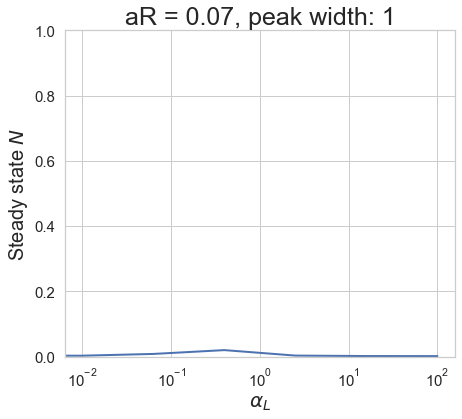

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  9.186498168629534e-05
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0005513155706254742
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.002646394250465826
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.006528034288694688
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.008430511770788731
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.00883267606028533
Cis-activation fold-diff: 71.08
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.0043280

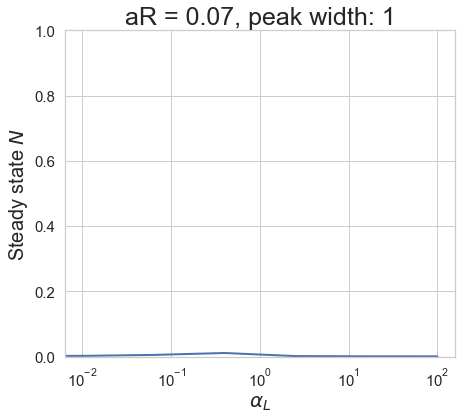

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  9.455924151489076e-05
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0005787762816711708
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.0030684960425579355
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.009610207820547757
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.014526751926416327
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.015824424568565084
Cis-activation fold-diff: 63.57
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432

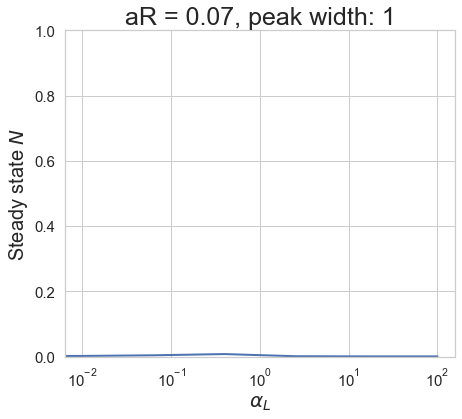

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  9.555275080643075e-05
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0005892782983966427
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.0032525900395580314
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.011489056426471914
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.019457127836564482
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.022014327699158273
Cis-activation fold-diff: 56.94
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432

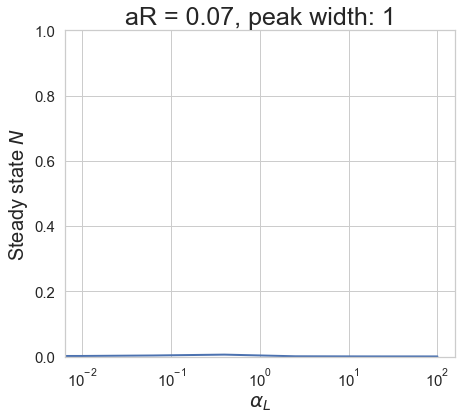

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  9.606963594046295e-05
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0005948288470670168
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.0033560039340171624
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.01275634885936521
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.023623810743530555
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.02792052870899609
Cis-activation fold-diff: 50.65
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.0043280

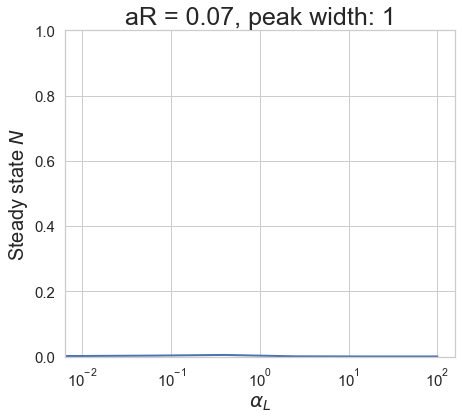

starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.00432808512266689 0.0014403345782775109
final C_minus =  9.638653498965152e-05
starting R, L, N at 0.07986910815968436 0.027310217124028077 0.0014403345782775109
final C_minus =  0.0005982622774801615
starting R, L, N at 0.07986910815968436 0.1723010687333689 0.0014403345782775109
final C_minus =  0.003422296536203405
starting R, L, N at 0.07986910815968436 1.087171701962696 0.0014403345782775109
final C_minus =  0.013669342609213327
starting R, L, N at 0.07986910815968436 6.859538830063528 0.0014403345782775109
final C_minus =  0.027276064515417763
starting R, L, N at 0.07986910815968436 43.2808512266689 0.0014403345782775109
final C_minus =  0.03435059520531513
Cis-activation fold-diff: 43.86
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.07986910815968436 0.0 0.0014403345782775109
final C_minus =  0.0
starting R, L, N at 0.07986910815968436 0.0043280

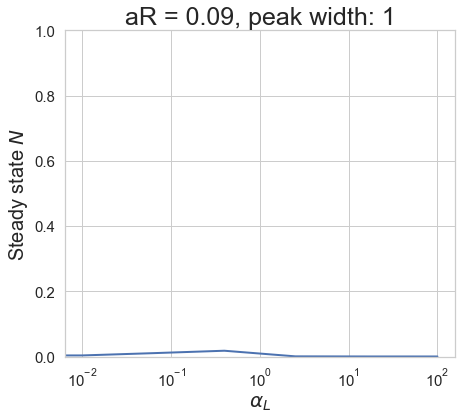

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.00011571734035496806
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0006958566388567912
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0033682790756652914
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.008407748675364793
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.01090531142073489
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.011435372698442095
Cis-activation fold-diff: 71.02
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432

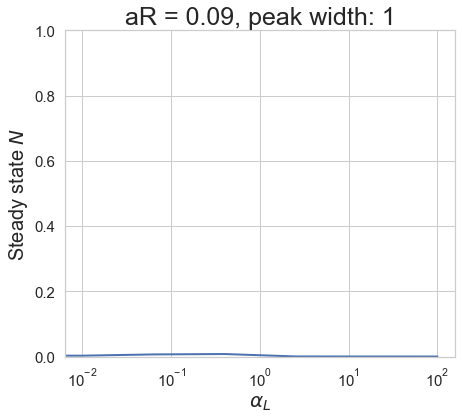

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.00011984822728181083
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0007341566923817848
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.003908208431920434
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.012388597409014032
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.019038723615872943
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09688209533618329
Cis-activation fold-diff: 58.53
Cis-inhibition efficacy: 98.61 %


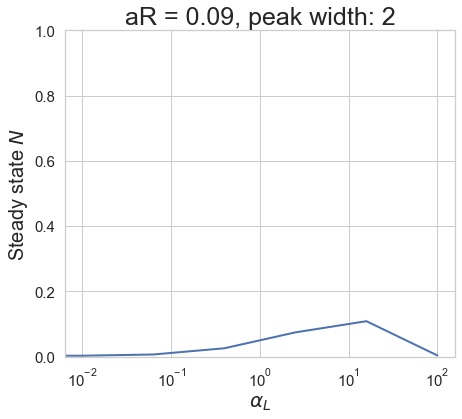

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  6.235375782247219e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0003828356024262374
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0020618778819243553
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.006708553442256811
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.0103644897690634
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.011336878815269428
Cis-activation fold-diff: 70.44
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.0043280

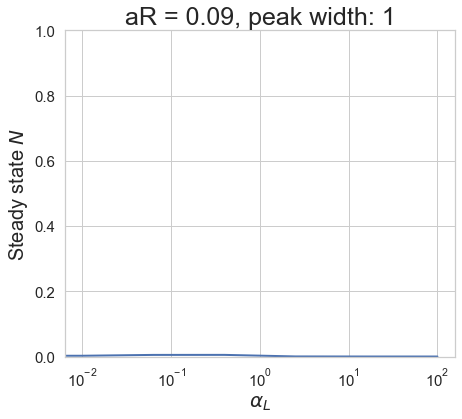

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.00012139485502247735
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0007490240492356312
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0041458943593673395
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.014829254075586355
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.02616383961906613
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09769027239798699
Cis-activation fold-diff: 50.53
Cis-inhibition efficacy: 99.71 %


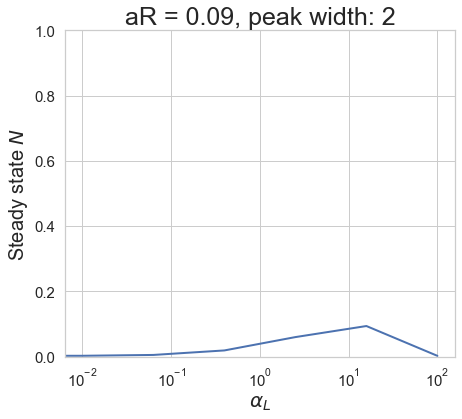

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  6.315405183622867e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.000390619491690451
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0021904367421679096
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.008106830187508334
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.014203027596442295
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.016160803189576998
Cis-activation fold-diff: 66.13
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.004328

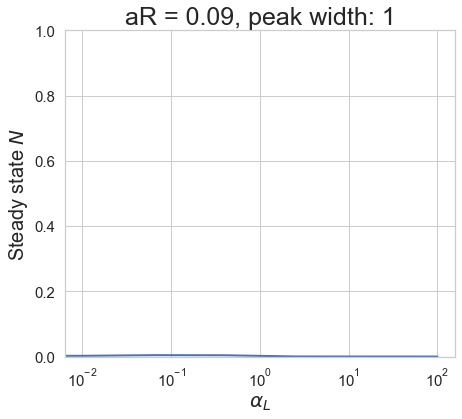

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.00012220459923137215
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0007569331042230975
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.004280095707117946
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.016483492394000637
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.06946799147940345
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09805626741617529
Cis-activation fold-diff: 26.96
Cis-inhibition efficacy: 100.59 %


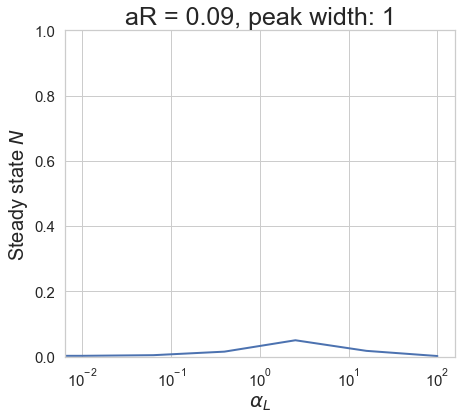

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  6.357299671435807e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.00039476039424446164
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0022631818522954403
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.009067929269998769
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.01752758040379428
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09154118334974937
Cis-activation fold-diff: 53.84
Cis-inhibition efficacy: 96.47 %


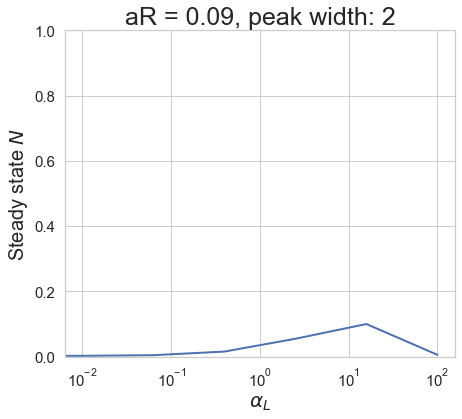

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  4.2961227463600876e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.00026701242363664823
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0015385702212920302
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.0062689411515685686
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.012242329260691812
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.014450267769361393
Cis-activation fold-diff: 66.82
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00

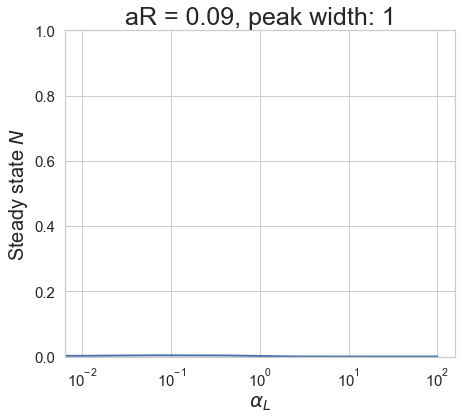

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  0.00012270278953120992
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.0007618435777765235
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.004366401184098128
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.017679650046156695
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.07348448451740855
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09826580036602414
Cis-activation fold-diff: 23.2
Cis-inhibition efficacy: 101.46 %


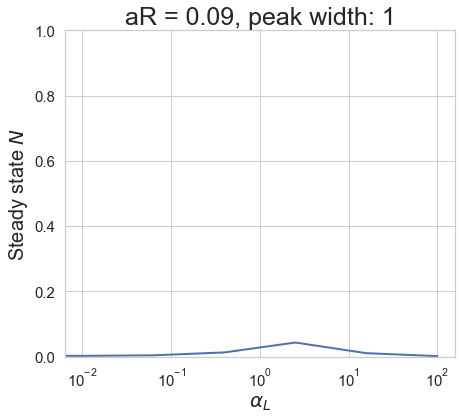

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  6.383073188925808e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.00039733136497560834
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.002310025998633859
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.009769852030973643
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.020466859215597755
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.09237838420158409
Cis-activation fold-diff: 49.48
Cis-inhibition efficacy: 97.61 %


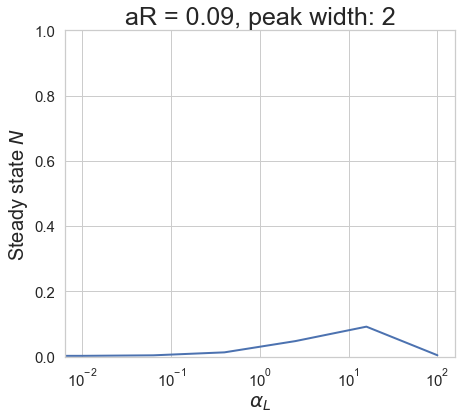

starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.00432808512266689 0.0018518587434996567
final C_minus =  4.3135057822169415e-05
starting R, L, N at 0.10268885334816559 0.027310217124028077 0.0018518587434996567
final C_minus =  0.000268753787997695
starting R, L, N at 0.10268885334816559 0.1723010687333689 0.0018518587434996567
final C_minus =  0.0015707180068549973
starting R, L, N at 0.10268885334816559 1.087171701962696 0.0018518587434996567
final C_minus =  0.006768265950443354
starting R, L, N at 0.10268885334816559 6.859538830063528 0.0018518587434996567
final C_minus =  0.014324643259982893
starting R, L, N at 0.10268885334816559 43.2808512266689 0.0018518587434996567
final C_minus =  0.01751246450717304
Cis-activation fold-diff: 63.92
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.10268885334816559 0.0 0.0018518587434996567
final C_minus =  0.0
starting R, L, N at 0.10268885334816559 0.004328

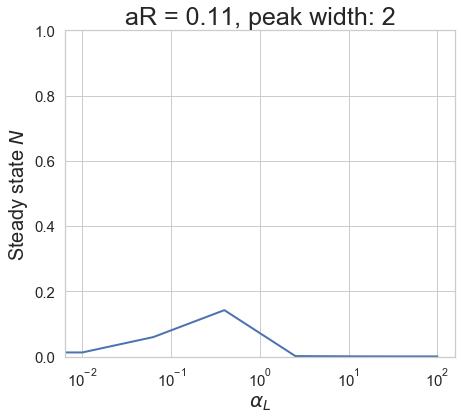

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.972838125937095e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0004001878996280533
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0007417185346499616
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.0007435667062354706
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.0007416187509460462
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.0007412762983817947
Cis-activation fold-diff: 80.08
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00

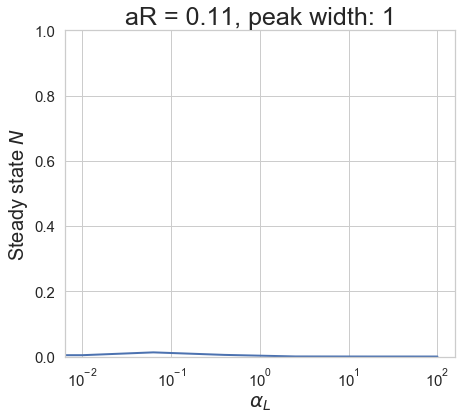

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.0001386206999040767
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0008351697208094411
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.004075608503774866
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.010300940564553418
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.01343471200459895
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12057169028126875
Cis-activation fold-diff: 67.8
Cis-inhibition efficacy: 100.94 %


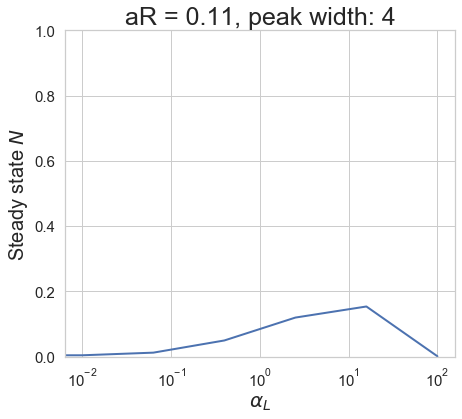

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.237715806536788e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00043678232508885485
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.002147460568081059
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.005479610573768574
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.007140736596068547
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.007489944066586029
Cis-activation fold-diff: 75.1
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.004328

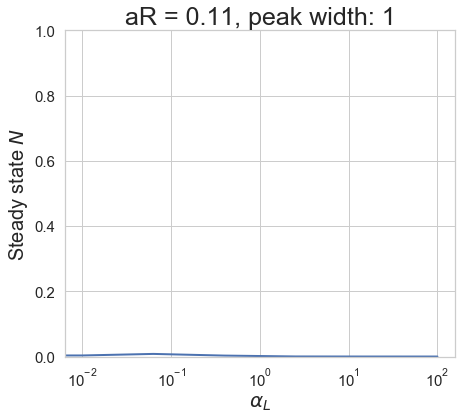

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.0001444176385550291
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0008853586375920962
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0047322920323323876
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.015210476837164649
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.09485181343584688
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12081694555455581
Cis-activation fold-diff: 39.82
Cis-inhibition efficacy: 102.03 %


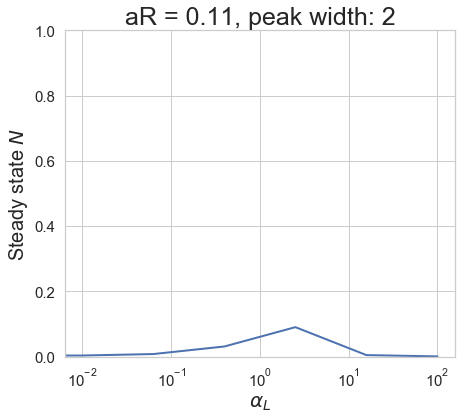

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.538294453188122e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.000463116371543819
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0025019575820735386
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.00820279478780425
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.012754316493995096
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11516590958981794
Cis-activation fold-diff: 64.59
Cis-inhibition efficacy: 100.59 %


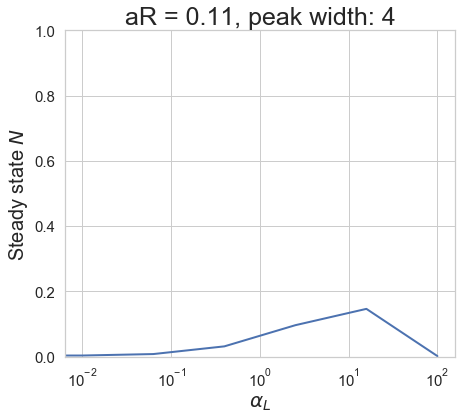

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  5.1002884375409944e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00031358016050037123
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.001700879128689119
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.0056283994550813295
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.008775354720643435
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.009613954438426725
Cis-activation fold-diff: 73.09
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.004

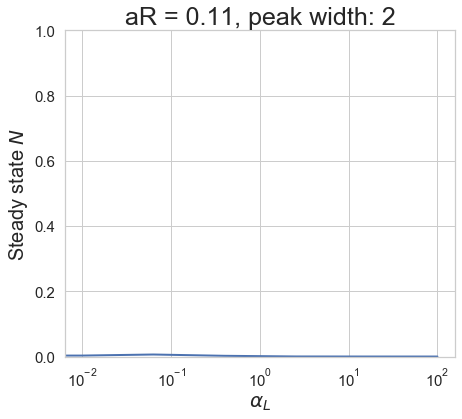

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.00014662027843454696
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0009051168072838937
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.005024004442996792
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.01825295280442136
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.09563160965242491
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12089902800847022
Cis-activation fold-diff: 31.94
Cis-inhibition efficacy: 102.73 %


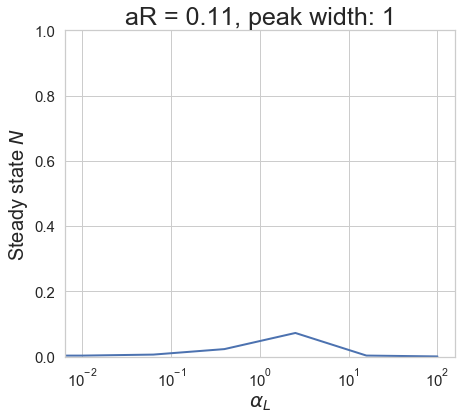

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.65245464518806e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0004734831615683441
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0026601440397442597
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.009912865422304866
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.017595339798042422
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11543125868431238
Cis-activation fold-diff: 58.61
Cis-inhibition efficacy: 100.97 %


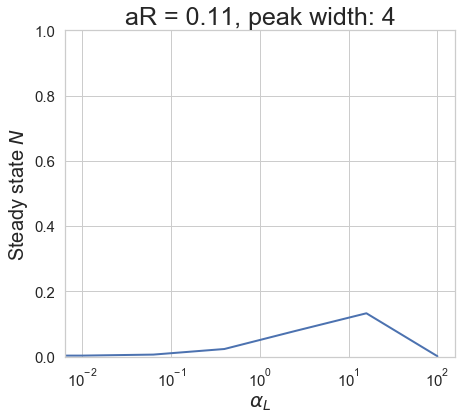

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  5.1773325739570056e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00032060712100397376
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.001809414690249766
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.0068278859547814584
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.012142759327650738
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11004458849295179
Cis-activation fold-diff: 61.68
Cis-inhibition efficacy: 100.04 %


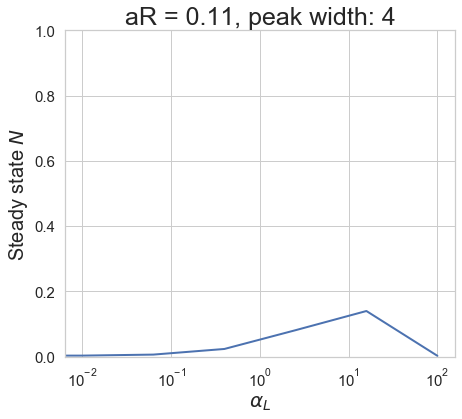

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  3.912026075519087e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00024235787596431902
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0013710344698284367
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.005210095623921382
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.009300949807791331
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.01061208843052294
Cis-activation fold-diff: 71.8
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.004328

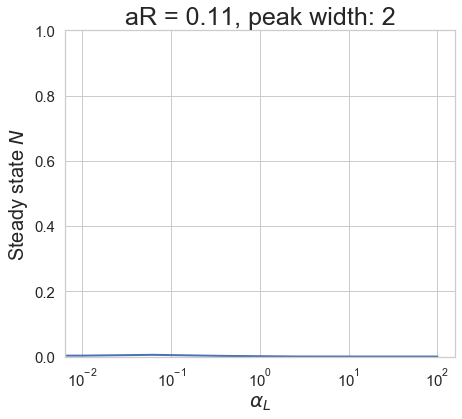

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.00014778063968863396
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0009156931772002438
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.005189528252889015
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.020334844348239123
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.09598721160085297
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12094013936305598
Cis-activation fold-diff: 26.65
Cis-inhibition efficacy: 103.4 %


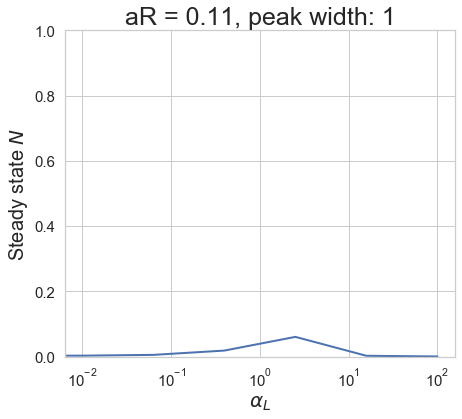

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.712583645070552e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0004790322757631295
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.002750102209003855
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.011090088731496401
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.02193295511204641
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11556088851443458
Cis-activation fold-diff: 53.36
Cis-inhibition efficacy: 101.24 %


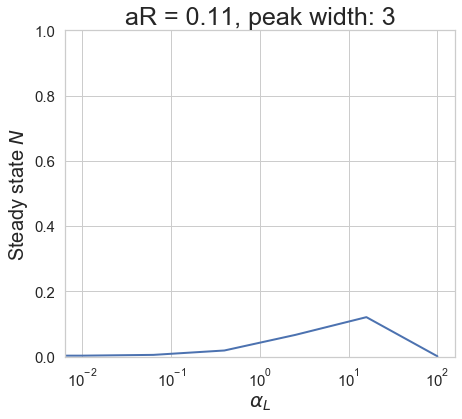

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  5.2179096064937434e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0003243684602095462
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0018711876201500132
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.007658591964346829
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.015099178904817129
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11036125113715142
Cis-activation fold-diff: 57.14
Cis-inhibition efficacy: 100.45 %


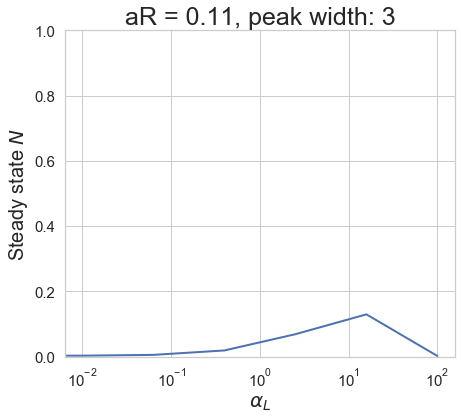

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  3.942646221045675e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00024520270229468484
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0014180717542861359
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.005852742750914831
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.011589525436013826
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.10509823491717758
Cis-activation fold-diff: 59.03
Cis-inhibition efficacy: 99.15 %


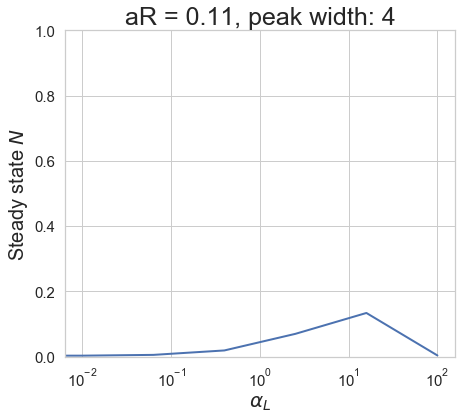

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  3.168309029158447e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00019709901674842101
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0011416411665201873
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.00473694531877192
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.00941815261333449
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.011163544287769226
Cis-activation fold-diff: 70.81
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.004328

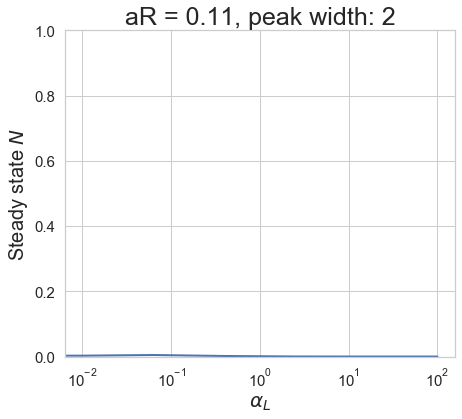

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  0.0001484970141795689
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0009222830576215726
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.005296310807283938
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.021851748971443544
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.09619144509447103
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.12096482961682736
Cis-activation fold-diff: 22.86
Cis-inhibition efficacy: 104.06 %


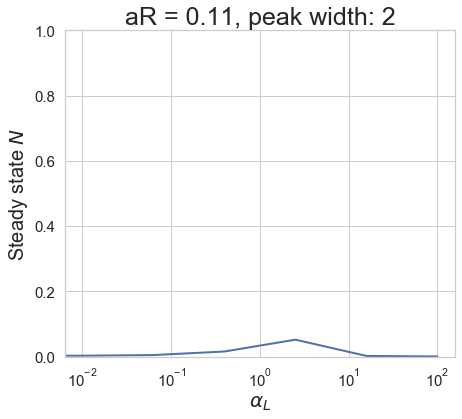

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  7.749701738760413e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0004824897362587085
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0028082140392697726
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.01195100501481024
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.02598879758595746
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11563775186073491
Cis-activation fold-diff: 48.58
Cis-inhibition efficacy: 101.48 %


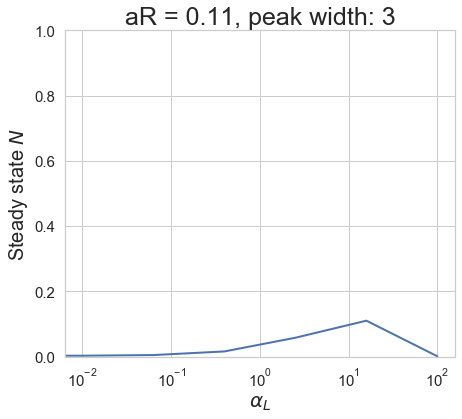

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  5.24295719348013e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00032671200412900714
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0019111118188638145
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.008268724002653086
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.017735260376530997
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.11054387360262129
Cis-activation fold-diff: 53.14
Cis-inhibition efficacy: 100.73 %


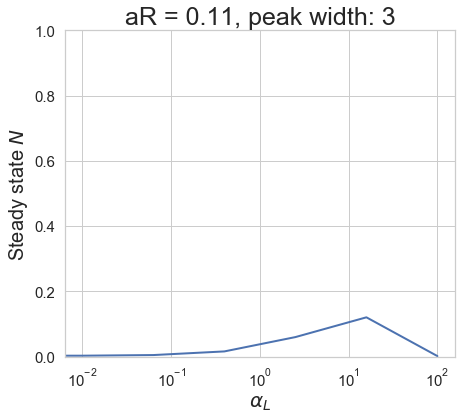

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  3.961547214072435e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.00024697519623582314
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.001448479996862857
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.006325977265758013
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.01362310225925742
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.10550106238924183
Cis-activation fold-diff: 55.3
Cis-inhibition efficacy: 99.65 %


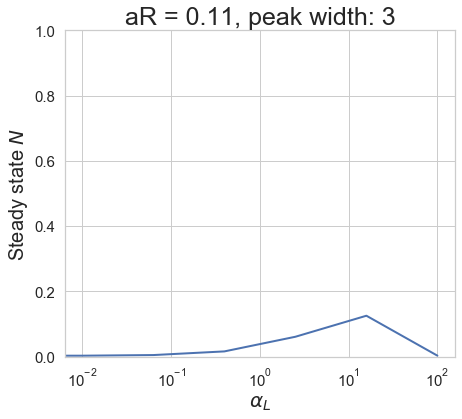

starting R, L, N at 0.12550859853664684 0.0 0.0022633829087218026
final C_minus =  0.0
starting R, L, N at 0.12550859853664684 0.00432808512266689 0.0022633829087218026
final C_minus =  3.18348568576775e-05
starting R, L, N at 0.12550859853664684 0.027310217124028077 0.0022633829087218026
final C_minus =  0.0001985242314561952
starting R, L, N at 0.12550859853664684 0.1723010687333689 0.0022633829087218026
final C_minus =  0.0011661968146833394
starting R, L, N at 0.12550859853664684 1.087171701962696 0.0022633829087218026
final C_minus =  0.005123601466401987
starting R, L, N at 0.12550859853664684 6.859538830063528 0.0022633829087218026
final C_minus =  0.011086259588053435
starting R, L, N at 0.12550859853664684 43.2808512266689 0.0022633829087218026
final C_minus =  0.01362042765901767
Cis-activation fold-diff: 68.67
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.0043280851

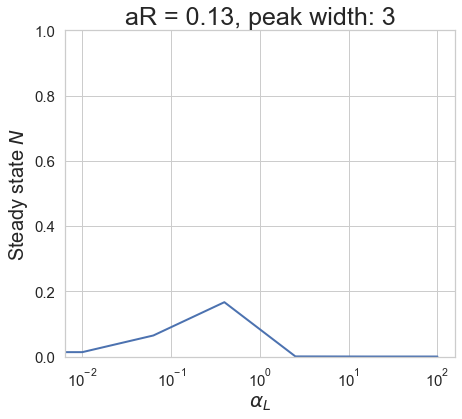

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  9.086918493511811e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.00046801901875760996
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0008994221202494359
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.0008825715198051915
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.0008771662808548929
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.0008762844256363669
Cis-activation fold-diff: 80.08
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 

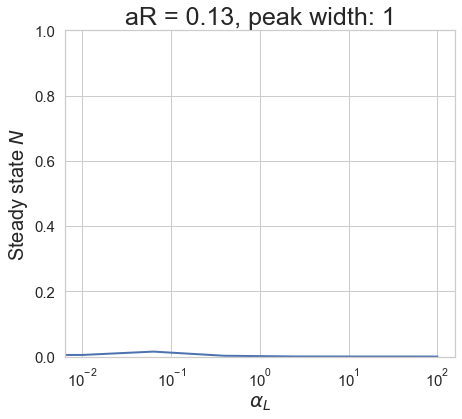

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  0.00016063014027515053
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.000969519195356126
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.004768743592769938
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.01221344062517543
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.11390851481269526
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.1430141617129515
Cis-activation fold-diff: 52.63
Cis-inhibition efficacy: 101.78 %


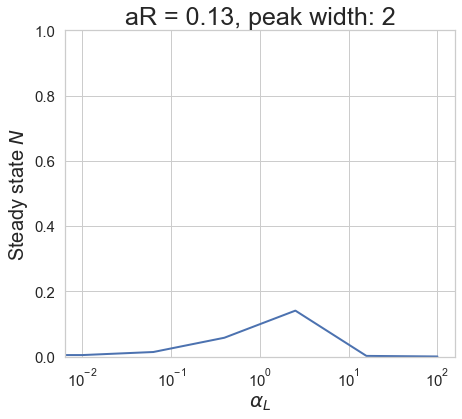

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  8.415211536151247e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0005086413350545177
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0025177700696225446
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.006483214687210595
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.008465185199184905
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.008880782646846292
Cis-activation fold-diff: 75.08
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.00

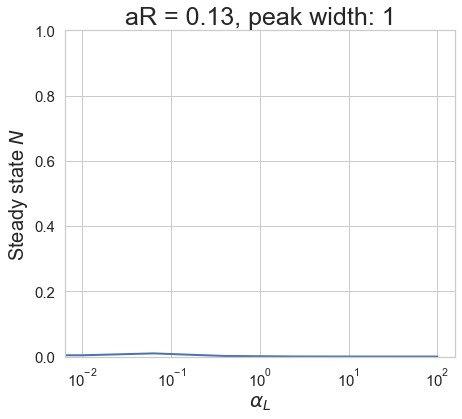

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  0.00016829222842990036
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0010325154389945479
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0055411897736230556
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.018105417882658487
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.11427181373335436
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.14304438497301777
Cis-activation fold-diff: 39.54
Cis-inhibition efficacy: 102.43 %


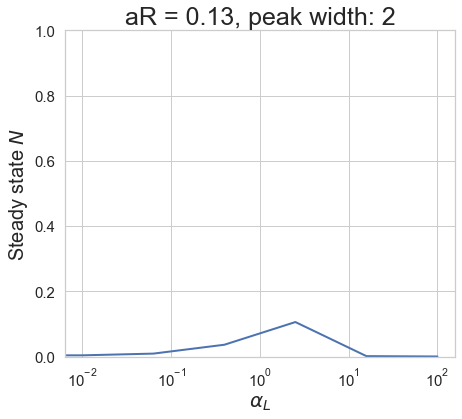

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  8.81322313403726e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0005417657460215223
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0029357336361458537
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.009701893134081166
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.015207203997793475
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.13691768604646662
Cis-activation fold-diff: 64.47
Cis-inhibition efficacy: 101.34 %


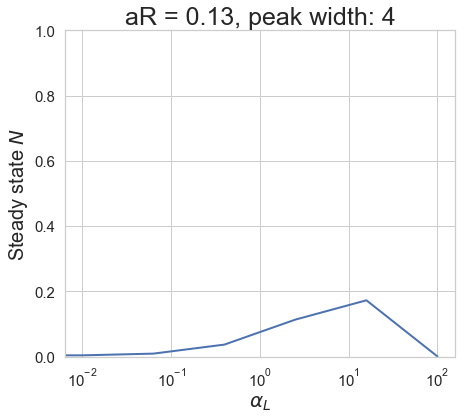

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  5.969784769016998e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0003672399386387506
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0019973945855155063
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.006651961673536614
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.010413544346084084
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.13120715222826046
Cis-activation fold-diff: 66.84
Cis-inhibition efficacy: 101.1 %


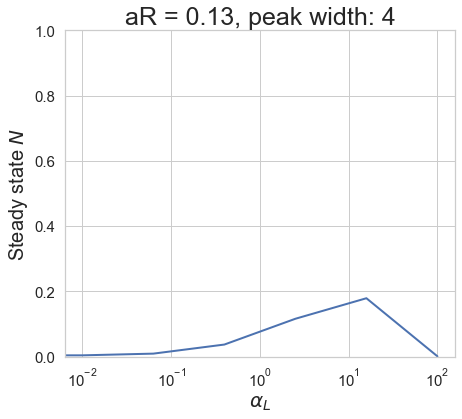

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  4.5135661253993484e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.00027776347280036113
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0015136902696469463
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.0050638178926748914
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.007936153539296737
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.008700823890987532
Cis-activation fold-diff: 74.49
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0

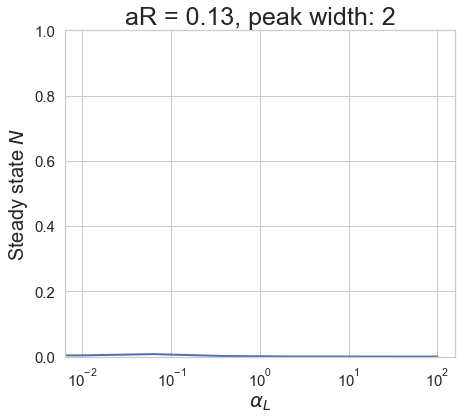

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  0.00017124551684996828
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0010576495941376893
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.005887364312492567
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.02182812706332082
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.11439273272230494
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.14305477576209513
Cis-activation fold-diff: 31.55
Cis-inhibition efficacy: 103.08 %


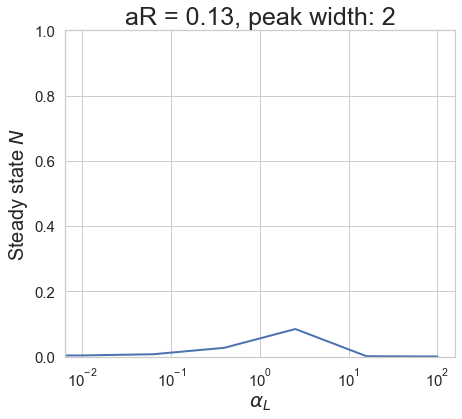

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  8.966543505793033e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0005549799823540552
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0031238909342477224
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.011727452568709263
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.09000688922683693
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.13695209773338948
Cis-activation fold-diff: 34.55
Cis-inhibition efficacy: 102.6 %


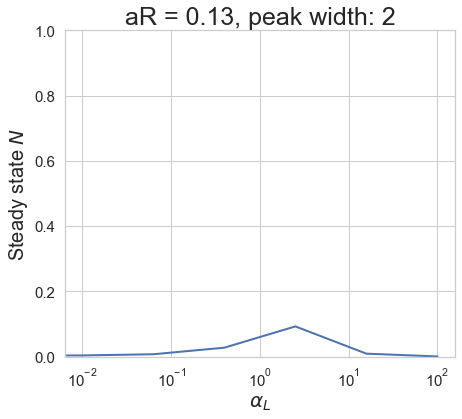

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  6.073316275928931e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.00037620349870954055
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0021266232843628946
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.008067880160623361
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.01445975297195157
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.13129095653256653
Cis-activation fold-diff: 61.57
Cis-inhibition efficacy: 101.28 %


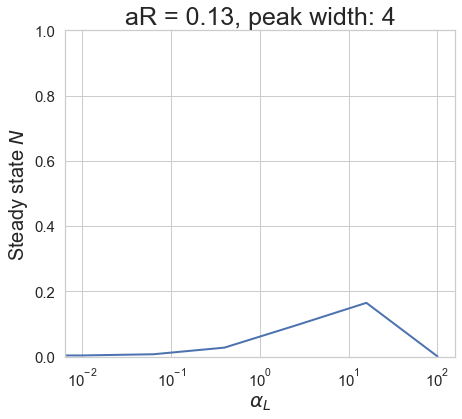

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  4.591717978953626e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.0002845454796374549
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0016121040790287847
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.006154259831373392
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.011040044529063911
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.1259795230145085
Cis-activation fold-diff: 63.19
Cis-inhibition efficacy: 100.99 %


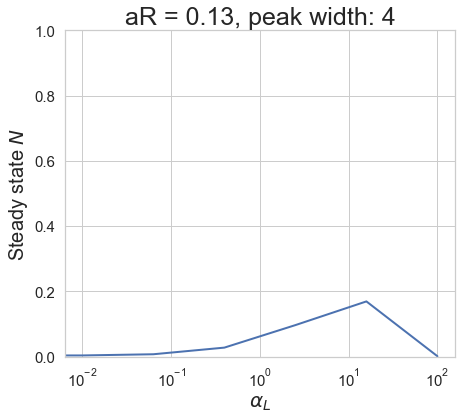

starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.002674907073943949
final C_minus =  3.691235257861216e-05
starting R, L, N at 0.1483283437251281 0.027310217124028077 0.002674907073943949
final C_minus =  0.00022880122690708532
starting R, L, N at 0.1483283437251281 0.1723010687333689 0.002674907073943949
final C_minus =  0.0012980765974990854
starting R, L, N at 0.1483283437251281 1.087171701962696 0.002674907073943949
final C_minus =  0.004975585071753763
starting R, L, N at 0.1483283437251281 6.859538830063528 0.002674907073943949
final C_minus =  0.008941704288895201
starting R, L, N at 0.1483283437251281 43.2808512266689 0.002674907073943949
final C_minus =  0.010217297375819008
Cis-activation fold-diff: 73.02
Cis-inhibition efficacy: 0.0 %
starting R, L, N at 0.1483283437251281 0.0 0.002674907073943949
final C_minus =  0.0
starting R, L, N at 0.1483283437251281 0.00432808512266689 0.0

KeyboardInterrupt: 

<Figure size 504x432 with 0 Axes>

In [142]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4

Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    for Kd_t in Kd_t_vals:
        for Kd_c in Kd_c_vals:
            
            # Define ligand range for titration- x axis for plot; adding ligands 
            aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0 # simulation of 48 hours
            interval = 5 # 5 minutes between time steps

            convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                                      hr, interval, convergence_crit)

            # Print cis-activation and -inhibition metrics
            print('Cis-activation fold-diff:', cis_act)
            print('Cis-inhibition efficacy:', cis_inh, '%')

            # Added this in to quantify peak width 
            for i, element in enumerate(significant_change(aL_vals)):
                if element == 1:
                    start_of_peak = i
                    break

            for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
                if element == 1:
                    end_of_peak = i + 1
                    break

            peak_width = end_of_peak - start_of_peak

            # Plot
           
            if (cis_act>1.5) & (cis_inh >90):
                fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                plt.plot(aL_vals, N_vect)
                plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
                plt.ylabel('Steady state $N$')
                plt.xlabel('$\\alpha_L$')
                plt.ylim((0,1))
                ax.set_xscale('log')
                plt.show()
    
    

# Plotting aR, Kd_t, and Kd_c by peak width

In [179]:
# Define params values that give good fold differences at reasonably high production rates
# Receptor = Notch1, Ligand = Dll4
master_array = np.array(())

Kd_t_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
Kd_c_vals = np.around(np.linspace(0.1,10,num=6),decimals =4)
aR_vals = np.around(np.linspace(.05, 0.15, num=6), decimals=4) # this range of aR values gives good curve
gR = np.log(2) / .8
dR = 0.01
gT = np.log(2) / .07
# aL = 0.4
gC = gR # setting gC == gR for now
gL = np.log(2) / .3
gN = np.log(2) / 1.25

for aR in aR_vals:
    for Kd_t in Kd_t_vals:
        for Kd_c in Kd_c_vals:
            
            # Define ligand range for titration- x axis for plot; adding ligands 
            aL_vals = np.around(np.logspace(-2, 2, num=6, base=10.0), decimals=4)
            aL_vals = np.insert(aL_vals, 0, 0)

            circuit_params = (Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN)

            # Define time series
            hr = 48.0 # simulation of 48 hours
            interval = 5 # 5 minutes between time steps

            convergence_crit = 1 # ≤ 1 percent change in 5 minutes = steady state achieved

            # Simulate ligand titration
            N_vect, cis_act, cis_inh = titrate_ligand(aL_vals, circuit_params, 
                                                      hr, interval, convergence_crit)

            # Print cis-activation and -inhibition metrics
            #print('Cis-activation fold-diff:', cis_act)
            #print('Cis-inhibition efficacy:', cis_inh, '%')

            # Added this in to quantify peak width 
            for i, element in enumerate(significant_change(aL_vals)):
                if element == 1:
                    start_of_peak = i
                    break

            for i, element in reversed(list(enumerate(significant_change(aL_vals)))):
                if element == 1:
                    end_of_peak = i + 1
                    break

            peak_width = end_of_peak - start_of_peak
            Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN = circuit_params
            
            create_list = [Kd_t, Kd_c, aR, gR, dR, gT, aL_vals[0], gL, gC, gN, cis_act,cis_inh, peak_width]
            
            master_array = np.append(master_array,create_list)
            #print(master_array)
            
            # Plot
            '''
            if (cis_act>1.5) & (cis_inh >90):
                fig, ax = plt.subplots(1, 1, figsize=(7, 6))
                plt.plot(aL_vals, N_vect)
                plt.title('aR = ' + str(aR)+', peak width: '+str(peak_width))
                plt.ylabel('Steady state $N$')
                plt.xlabel('$\\alpha_L$')
                plt.ylim((0,1))
                ax.set_xscale('log')
                plt.show()
            '''

In [184]:
rows = master_array.size/13

216.0

In [185]:
master_array = master_array.reshape((int(rows),13))

In [186]:
masterdf = pd.DataFrame(master_array)

In [187]:
masterdf.columns = ['Kd_t', 'Kd_c', 'aR', 'gR', 'dR', 'gT', 'aL_vals[0]', 'gL', 'gC', 'gN', 'cis_act','cis_inh', 'peak_width']

In [188]:
masterdf.head()

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,peak_width
0,0.1,0.10,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.72,0.0,2.0
1,0.1,2.08,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,80.08,0.0,2.0
2,0.1,4.06,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,80.31,0.0,2.0
3,0.1,6.04,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,80.39,0.0,2.0
4,0.1,8.02,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,80.43,0.0,2.0


# when $Kd_t=Kd_c \implies$ larger peak width

ValueError: `bins` must increase monotonically, when an array

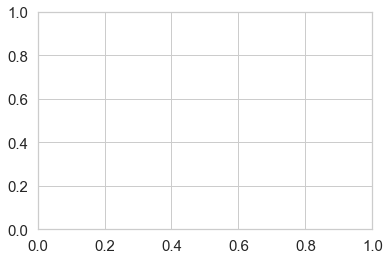

In [216]:
plt.hist(df_subset['aR'],df_subset['peak_width'])

In [211]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[1])
print('Kd_c',Kd_c_vals[1])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])


Loading BokehJS ...

Kd_t 2.08
Kd_c 2.08


In [207]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[0],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[0])
print('Kd_c',Kd_c_vals[1])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

Loading BokehJS ...

Kd_t 0.1
Kd_c 2.08


In [208]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[0],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[0],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[0])
print('Kd_c',Kd_c_vals[0])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

Loading BokehJS ...

Kd_t 0.1
Kd_c 0.1


In [209]:
df_subset = masterdf.loc[(masterdf['Kd_t']==np.around(Kd_t_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[0],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='aR',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='aR',
    y='peak_width'
)

bokeh.io.show(p)

print('Kd_t',Kd_t_vals[1])
print('Kd_c',Kd_c_vals[0])

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

Loading BokehJS ...

Kd_t 2.08
Kd_c 0.1


In [202]:
df_subset = masterdf.loc[(masterdf['aR']==np.around(aR_vals[1],decimals=4)) &\
                         (masterdf['Kd_c']==np.around(Kd_c_vals[1],decimals=4))]
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

p = bokeh.plotting.figure(
    frame_width=400,
    frame_height=300,
    x_axis_label='Kd_t',
    y_axis_label='peak_width',
    #x_axis_type='log'
)

p.circle(
    source=df_subset,
    x='Kd_t',
    y='peak_width'
)

bokeh.io.show(p)

#plt.scatter(masterdf['Kd_t'],masterdf['peak_width'])

Loading BokehJS ...

Kd_t and Kd_c both showed constant peak width acorss the range I chose

In [217]:
df_subset

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,peak_width
7,2.08,2.08,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.13,0.00,2.0
43,2.08,2.08,0.07,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.08,0.00,1.0
79,2.08,2.08,0.09,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.02,0.00,1.0
115,2.08,2.08,0.11,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,67.80,100.94,4.0
151,2.08,2.08,0.13,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,52.63,101.78,2.0
187,2.08,2.08,0.15,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,52.45,101.85,2.0


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <a list of 10 Patch objects>)

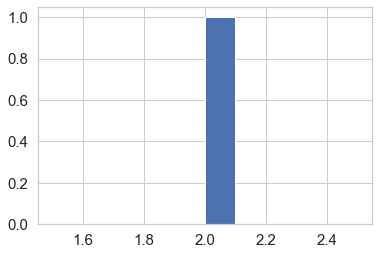

In [220]:
plt.hist(df_subset.loc[df_subset['aR']==aR_vals[0]]['peak_width'])

In [221]:
df_subset.loc[df_subset['aR']==aR_vals[0]]['peak_width']

7    2.0
Name: peak_width, dtype: float64

In [222]:
df_subset

,Kd_t,Kd_c,aR,gR,dR,gT,aL_vals[0],gL,gC,gN,cis_act,cis_inh,peak_width
7,2.08,2.08,0.05,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.13,0.00,2.0
43,2.08,2.08,0.07,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.08,0.00,1.0
79,2.08,2.08,0.09,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,71.02,0.00,1.0
115,2.08,2.08,0.11,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,67.80,100.94,4.0
151,2.08,2.08,0.13,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,52.63,101.78,2.0
187,2.08,2.08,0.15,0.866434,0.01,9.902103,0.0,2.310491,0.866434,0.554518,52.45,101.85,2.0
